In [2]:
!pip install kora -q
from kora import drive
drive.link_nbs()

In [3]:
import utils
from google.colab.patches import cv2_imshow

importing Jupyter notebook from /nbs/utils.ipynb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# SF_notloaded = True   #set to True after first run once you have your files in the Files folder of Colab 

In [ ]:
# if not SF_notloaded:
#   utils.onceSF()

In [ ]:
!pip install efficientnet

     |████████████████████████████████| 50 kB 4.9 MB/s 


In [7]:
import tensorflow as tf
from keras import layers
from keras.callbacks import TensorBoard, LearningRateScheduler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
#import efficientnet.keras as efn 
from utils import *
from keras.models import Sequential, Model,load_model
from keras import backend as K
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D, Dropout, GlobalAveragePooling2D, Lambda
#from keras.layers import Input, Conv2D, ReLU, BatchNormalization,Add, AveragePooling2D, Flatten, Dense
from keras.initializers import glorot_uniform
import collections
import tensorflow
from tensorflow import Tensor


In [5]:
""" Global variables """
IMG_SIZE = (224,224)
EPOCHS = 30
BATCH_SIZE = 32
NUM_CLASSES = 40 # 40 classes in the Stanford40 dataset

#utils.onceSF()

""" Load Stanford40 dataset """
#Load the dataset which has already been preprocessed, set needDirectories to False if SF_train, SF_test, and SF_validation dirs already exist
train_ds, test_ds, val_ds, train_labels, test_labels, validation_labels, class_names = utils.loadSF40(img_size =  IMG_SIZE, needDirectories=False)

#https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices
#http://man.hubwiz.com/docset/TensorFlow_2.docset/Contents/Resources/Documents/tf/data/Dataset.html 


Streaming output truncated to the last 5000 lines.
  inflating: Stanford40/JPEGImages/phoning_216.jpg  
  inflating: Stanford40/JPEGImages/phoning_217.jpg  
  inflating: Stanford40/JPEGImages/phoning_218.jpg  
  inflating: Stanford40/JPEGImages/phoning_219.jpg  
  inflating: Stanford40/JPEGImages/phoning_220.jpg  
  inflating: Stanford40/JPEGImages/phoning_221.jpg  
  inflating: Stanford40/JPEGImages/phoning_222.jpg  
  inflating: Stanford40/JPEGImages/phoning_223.jpg  
  inflating: Stanford40/JPEGImages/phoning_224.jpg  
  inflating: Stanford40/JPEGImages/phoning_225.jpg  
  inflating: Stanford40/JPEGImages/phoning_226.jpg  
  inflating: Stanford40/JPEGImages/phoning_227.jpg  
  inflating: Stanford40/JPEGImages/phoning_228.jpg  
  inflating: Stanford40/JPEGImages/phoning_229.jpg  
  inflating: Stanford40/JPEGImages/phoning_230.jpg  
  inflating: Stanford40/JPEGImages/phoning_231.jpg  
  inflating: Stanford40/JPEGImages/phoning_232.jpg  
  inflating: Stanford40/JPEGImages/phoning_233.j

In [8]:
""" One-hot encoding """

def onehot_encoding(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

#Apply one hot encoding to the different datasets
train_ds = train_ds.map(onehot_encoding, num_parallel_calls=tf.data.AUTOTUNE)
#train_ds = train_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(onehot_encoding, num_parallel_calls=tf.data.AUTOTUNE)
#val_ds = val_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(onehot_encoding)
#test_ds = test_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)

print("Done one-hot encoding!")


Done one-hot encoding!


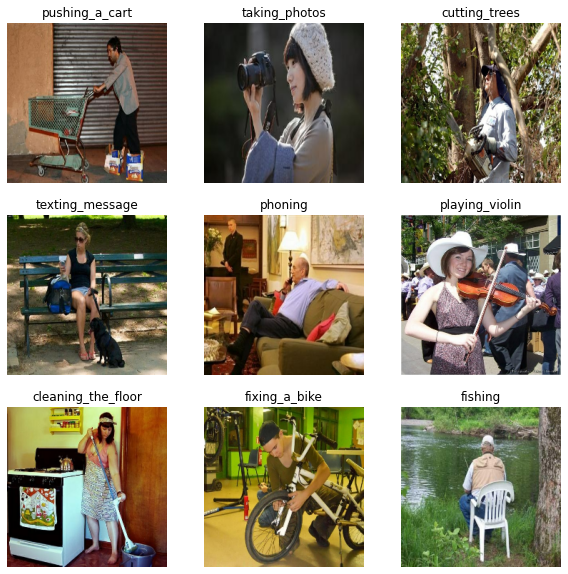

In [6]:
#Visualize Data1
def format_label(label):
    index=[i for i, e in enumerate(label) if e == 1]
    return class_names[index[0]]
    #return string_label.split("-")[1]

plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title("{}".format(format_label(label[i])))
    plt.axis("off")

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(40,), dtype=float32)
indexis:  [31]
(224, 224, 3)
texting_message


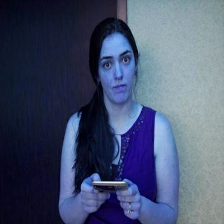

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(40,), dtype=float32)
indexis:  [14]
(224, 224, 3)
holding_an_umbrella


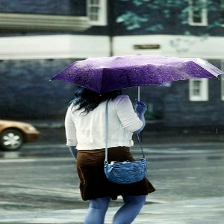

In [7]:
#Visualize data2
import matplotlib.pyplot as plt


for images, labels in train_ds.take(2):
  print(labels[0])
  index=[i for i, e in enumerate(labels[0]) if e == 1]
  print("indexis: ",index)
  print(images[0].shape)
  print(class_names[index[0]])
  cv2_imshow(images[0].numpy().astype("uint8"))

In [8]:
def Res_Net_input(input_value, filtersize = 64):
    starting_point = -1
    input_layer = input_value
    
    ############ The first convolutional layer ##############
    input_value = Conv2D(filtersize, kernel_size=(3,3), padding="same")(input_value)
    input_value = Activation("relu")(input_value)
    input_value = BatchNormalization(axis=starting_point)(input_value) #()
    
    ############ The second convolutional layer ##############
    input_value = Conv2D(filtersize, kernel_size=(3,3), padding="same")(input_value)
    input_value = Activation("relu")(input_value)
    input_value = BatchNormalization(axis=starting_point)(input_value)
    
    input_value = Add()([input_layer, input_value])
    
    input_layer = Activation("relu")(input_layer)
    
    return input_value

In [59]:
# def Res_Net_Model(w, h, d, c):
#     filtersize = 32
#     inputShape = (w, h, d)
#     starting_point = -1 
    
    
#     input_value = Input(inputShape)
#     output_layer = input_value
    
#     ############# The first convolutional layer ##############
#     output_layer = Conv2D(filters=16, kernel_size=(7,7), padding="same")(output_layer)
#     output_layer = Activation("relu")(output_layer) ## (112 - 7 + 2 * 3)/1 +1 = 112
#     output_layer = BatchNormalization(axis=starting_point)(output_layer)
   
#     ############ The first maxpooling layer ##############
#     output_layer = MaxPooling2D(pool_size=(2,2), strides=2)(output_layer) #56
    
#     ############ Adding the ResNet layers ##############
#     output_layer = Res_Net_input(output_layer, 16) # 28
    
#     ############# The second maxpooling layer ##############
#     output_layer = MaxPooling2D(pool_size=(2,2), strides=2)(output_layer) # 28

#     ############# The second convolutional layer ##############
#     output_layer = Conv2D(filters=16, kernel_size=(3,3), padding="same")(output_layer)
#     output_layer = Activation("relu")(output_layer) # (56 - 5 + 2 * 2)/1 + 1 = 56
#     output_layer = BatchNormalization(axis=starting_point)(output_layer)


#     ############# The second maxpooling layer ##############
#     output_layer = MaxPooling2D(pool_size=(2,2), strides=2)(output_layer) # 28

    
#     ############# The third convolutional layer ##############
#     output_layer = Conv2D(filters=32, kernel_size=(3,3), padding="same")(output_layer)
#     output_layer = Activation("relu")(output_layer) # 14
#     output_layer = BatchNormalization(axis=starting_point)(output_layer)
    
#     ############# The fourth convolutional layer ##############
#     output_layer = MaxPooling2D(pool_size=(2,2), strides=2)(output_layer)
    
#     ############ The connection layer ##############
#     output_layer = Flatten()(output_layer)
#     output_layer = Dense(128)(output_layer)
#     output_layer = Activation("relu")(output_layer)
#     output_layer = BatchNormalization(axis=starting_point)(output_layer)
#     output_layer = Dropout(0.25)(output_layer)
    
#     ############ The output layer ##############
#     output_layer = Dense(c)(output_layer)
#     output_layer = Activation("softmax")(output_layer)
#     Model_ResNet = Model(inputs=input_value,outputs=output_layer)
        
#     # return the CNN 
#     return Model_ResNet

In [9]:
# def identity_block(X, f, filters, stage, block):
   
#     conv_name_base = 'res' + str(stage) + block + '_branch'
#     bn_name_base = 'bn' + str(stage) + block + '_branch'
#     F1, F2, F3 = filters

#     X_shortcut = X
   
#     X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
#     X = Activation('relu')(X)

#     X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
#     X = Activation('relu')(X)

#     X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

#     X = Add()([X, X_shortcut])# SKIP Connection
#     X = Activation('relu')(X)

#     return X

In [10]:
# def convolutional_block(X, f, filters, stage, block, s=2):
   
#     conv_name_base = 'res' + str(stage) + block + '_branch'
#     bn_name_base = 'bn' + str(stage) + block + '_branch'

#     F1, F2, F3 = filters

#     X_shortcut = X

#     X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
#     X = Activation('relu')(X)

#     X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
#     X = Activation('relu')(X)

#     X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

#     X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
#     X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

#     X = Add()([X, X_shortcut])
#     X = Activation('relu')(X)

#     return X

In [57]:
# def ResNet50(input_shape=(224, 224, 3)):

#     X_input = Input(input_shape)

#     X = ZeroPadding2D((3, 3))(X_input)

#     X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis=3, name='bn_conv1')(X)
#     X = Activation('relu')(X)
#     X = MaxPooling2D((3, 3), strides=(2, 2))(X)

#     X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
#     X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
#     X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


#     X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
#     X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
#     X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
#     X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

#     X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
#     X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
#     X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
#     X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
#     X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
#     X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

#     X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
#     X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
#     X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

#     X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
#     model = Model(inputs=X_input, outputs=X, name='ResNet50')

#     return model

In [98]:
# def relu_bn(inputs: Tensor) -> Tensor:
#     relu = ReLU()(inputs)
#     bn = BatchNormalization()(relu)
#     return bn

In [99]:
# def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
#     y = Conv2D(kernel_size=kernel_size,
#                strides= (1 if not downsample else 2),
#                filters=filters,
#                padding="same")(x)
#     y = relu_bn(y)
#     y = Conv2D(kernel_size=kernel_size,
#                strides=1,
#                filters=filters,
#                padding="same")(y)

#     if downsample:
#         x = Conv2D(kernel_size=1,
#                    strides=2,
#                    filters=filters,
#                    padding="same")(x)
#     out = Add()([x, y])
#     out = relu_bn(out)
#     return out

In [103]:
# def create_res_net():   #Resnet20
    
#     inputs = Input(shape=(224, 224, 3))
#     num_filters = 64
    
#     t = BatchNormalization()(inputs)
#     t = Conv2D(kernel_size=3,
#                strides=1,
#                filters=num_filters,
#                padding="same")(t)
#     t = relu_bn(t)
    
#     num_blocks_list = [2, 5, 5, 2]
#     for i in range(len(num_blocks_list)):
#         num_blocks = num_blocks_list[i]
#         for j in range(num_blocks):
#             t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
#         num_filters *= 2
    
#     t = AveragePooling2D(4)(t)
#     t = Flatten()(t)
#     outputs = Dense(40, activation='softmax')(t)
    
#     model = Model(inputs, outputs)

#     model.compile(
#         optimizer='adam',
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )

#     return model

In [9]:
class ResnetBlock(Model):  #Resnet18
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [10]:
model = ResNet18(40) # or create_plain_net()
model.build(input_shape = (None,224,224,3))
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy"])
#model = create_res_net()
model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 resnet_block (ResnetBlock)  multiple          

In [11]:
# #Baseline model architecture
# bl_model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu', input_shape=(224,224,3)),
#     tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu'),
#     tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
#     tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu'),
#     tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu'),
#     tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
#     tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation='relu'),
#     tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation='relu'),
#     tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation='relu'),
#     tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
#     tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation='relu'),
#     tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation='relu'),
#     tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation='relu'),
#     tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
#     tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation='relu'),
#     tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation='relu'),
#     tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation='relu'),
#     tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
#     tf.keras.layers.Flatten(),                     
#     tf.keras.layers.Dense(units=4096, activation='relu'),
#     tf.keras.layers.Dense(units=4096, activation='relu'),
#     tf.keras.layers.Dense(units=40, activation='softmax')
# ])
bl_model = ResNet50(input_shape=(224, 224, 3))
#bl_model = Res_Net_Model(224,224,3,40)

NameError: ignored

In [55]:
headModel = bl_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 40,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)
model = Model(inputs=bl_model.input, outputs=headModel)

In [65]:
bl_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 224, 224, 16  2368        ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 activation_229 (Activation)    (None, 224, 224, 16  0           ['conv2d_5[0][0]']               
                                )                                                           

In [12]:
#Compiling and fitting Maxpool model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("ResNet50_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='auto')

In [14]:
#hist = bl_model.fit_generator(steps_per_epoch=3200,generator=train_ds, validation_data= val_ds, validation_steps=10,epochs=100,callbacks=[checkpoint,early])
model_history=model.fit(train_ds, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=val_ds, callbacks=[checkpoint,early])

Epoch 1/30
113/113 [==============================] - ETA: 0s - loss: 3.6885 - accuracy: 0.0783
Epoch 1: val_accuracy improved from -inf to 0.03250, saving model to ResNet50_1.h5
113/113 [==============================] - 43s 250ms/step - loss: 3.6885 - accuracy: 0.0783 - val_loss: 11.5151 - val_accuracy: 0.0325
Epoch 2/30
113/113 [==============================] - ETA: 0s - loss: 3.2288 - accuracy: 0.1317
Epoch 2: val_accuracy improved from 0.03250 to 0.07250, saving model to ResNet50_1.h5
113/113 [==============================] - 28s 242ms/step - loss: 3.2288 - accuracy: 0.1317 - val_loss: 4.2222 - val_accuracy: 0.0725
Epoch 3/30
113/113 [==============================] - ETA: 0s - loss: 3.0060 - accuracy: 0.1867
Epoch 3: val_accuracy did not improve from 0.07250
113/113 [==============================] - 28s 243ms/step - loss: 3.0060 - accuracy: 0.1867 - val_loss: 5.5371 - val_accuracy: 0.0500
Epoch 4/30
113/113 [==============================] - ETA: 0s - loss: 2.8436 - accuracy: 

In [14]:
model = keras.models.load_model("ResNet50_1.h5")

ValueError: ignored

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


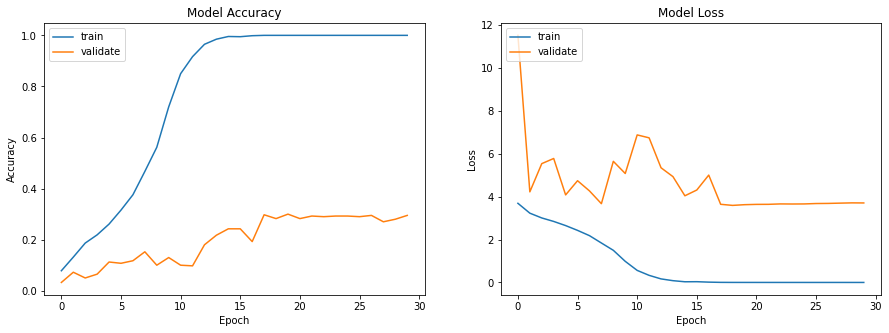

In [18]:
#Plot loss and accuracy
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(model_history.history.keys())
plotmodelhistory(model_history)

In [19]:
## Evaluation

ModelLoss, ModelAccuracy = model.evaluate(test_ds)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))

173/173 [==============================] - 16s 87ms/step - loss: 3.8296 - accuracy: 0.2661
Model Loss is 3.829630136489868
Model Accuracy is 0.26608821749687195


In [45]:
Y_pred = np.argmax(model.predict(test_ds),axis=1) 
print(Y_pred.shape)
#convert to string label
# labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
#str_pred = [labels[i] for i in Y_pred]
#str_pred
# sub["label"] = pd.DataFrame(str_pred)

(5532,)


In [1]:
#Visualize Data after prediction
def format_label(label):
    #index=[i for i, e in enumerate(label) if e == 1]
    return class_names[label]
    #return string_label.split("-")[1]

result = test_ds.unbatch()

images = np.asarray(list(result.map(lambda x, y: x)))
# labels = np.asarray(list(result.map(lambda x, y: y)))

plt.imshow(images[0].numpy().astype("uint8"))
# print(labels.shape)
# for i, (image, label) in enumerate(train_ds.take(9)):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(image[i].numpy().astype("uint8"))
#     plt.title("{}".format(format_label(Y_pred[i])))
#     plt.axis("off")

#plt.imshow(test_ds[0].numpy().astype("uint8"))

#test_ds.shape
# plt.figure(figsize=(10,10))
# for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(image[i].numpy().astype("uint8"))
#     plt.title("{}".format(format_label(Y_pred[i])))
#     plt.axis("off")
#     print(label.shape)
#print(Y_pred[0])

NameError: ignored

In [ ]:
""" Build & Train Stanford40 Model EfficientNet"""

# Define the input and output layers of the model 
inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

#Fetch image augmentation layers and apply to inputs
img_augmentation = dataAugmentation()
x = img_augmentation(inputs)

outputs = efn.EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(x) #Include top set to true as we are not using pre-trained weights but training from scratch


optimizer = tf.keras.optimizers.Adam(learning_rate=tf.Variable(0.01), beta_1=tf.Variable(0.9), beta_2=tf.Variable(0.999), epsilon=tf.Variable(1e-7),)
optimizer.iterations
optimizer.decay = tf.Variable(0.0)

# Initialise the model. Compule and show summary. 
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()


#Fit the model with the data augmentation and normalisation iterators    ### , steps_per_epoch = NO_TRAIN_IMGS//BATCH_SIZE ## validation_steps=NO_VAL_IMGS//BATCH_SIZE, 
history = model.fit(train_ds, epochs = EPOCHS, validation_data = val_ds, verbose=2)

#Save weights and model as we need these for transfer learning 
model.save_weights("model_weights", save_format='tf')
tf.keras.models.save_model(model, "SF_model", include_optimizer=True, save_format='tf')



#Plot loss and accuracy
plotAccuracy("Accuracy on Stanford 40", history.history['accuracy'], history.history['val_accuracy'])                     # made these plotting functions in utils for hassle-free plotting
plotLoss("Accuracy on Stanford 40", history.history['loss'], history.history['val_loss'])



AttributeError: ignored

In [ ]:
tf.keras.models.save_model(model, "NoOptimiser", include_optimizer=False, save_format='tf')

INFO:tensorflow:Assets written to: NoOptimiser/assets


In [ ]:
#Zip and download the model
!zip -r /content/SF_model.zip /content/SF_model
from google.colab import files
files.download("SF_model.zip")

  adding: content/SF_model/ (stored 0%)
  adding: content/SF_model/keras_metadata.pb (deflated 96%)
  adding: content/SF_model/saved_model.pb (deflated 91%)
  adding: content/SF_model/variables/ (stored 0%)
  adding: content/SF_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/SF_model/variables/variables.index (deflated 74%)
  adding: content/SF_model/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Zip and download the model
!zip -r /content/NoOptimiser.zip /content/NoOptimiser
from google.colab import files
files.download("NoOptimiser.zip")

  adding: content/NoOptimiser/ (stored 0%)
  adding: content/NoOptimiser/keras_metadata.pb (deflated 96%)
  adding: content/NoOptimiser/saved_model.pb (deflated 91%)
  adding: content/NoOptimiser/variables/ (stored 0%)
  adding: content/NoOptimiser/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/NoOptimiser/variables/variables.index (deflated 74%)
  adding: content/NoOptimiser/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
""" Tutorials used to build model"""
#https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
#https://towardsdatascience.com/an-in-depth-efficientnet-tutorial-using-tensorflow-how-to-use-efficientnet-on-a-custom-dataset-1cab0997f65c
#https://www.kaggle.com/code/arjunrao2000/beginners-guide-efficientnet-with-keras/notebook

""" Cyclical learning rate example"""
#https://pyimagesearch.com/2019/07/29/cyclical-learning-rates-with-keras-and-deep-learning/